# 시청률 예측 회귀 모델 개발 
---

### 필요한 컬럼만 추출
---

In [3]:
실적 =실적[실적['상품군']!='무형']
실적.reset_index(drop=True,inplace=True)
실적_전처리 = 실적[['노출(분)','상품군','판매단가범위','몇시','무슨요일','시청률평균']]

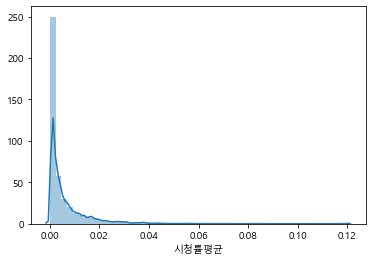

In [4]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',family = 'malgun gothic')

sns.distplot(실적_전처리['시청률평균'])

### 데이터 정규화
---

In [15]:


from sklearn.preprocessing import StandardScaler
x_data =실적_전처리[['시청률평균']]
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(x_data)
실적_전처리['시청률평균']=min_max_scaler.transform(x_data)


### 원핫인코딩
---

In [16]:

실적_전처리_원핫 = pd.get_dummies(실적_전처리)
실적_전처리_원핫.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37372 entries, 0 to 37371
Data columns (total 47 columns):
노출(분)             37372 non-null float64
시청률평균             37372 non-null float64
상품군_가구            37372 non-null uint8
상품군_가전            37372 non-null uint8
상품군_건강기능          37372 non-null uint8
상품군_농수축           37372 non-null uint8
상품군_생활용품          37372 non-null uint8
상품군_속옷            37372 non-null uint8
상품군_의류            37372 non-null uint8
상품군_이미용           37372 non-null uint8
상품군_잡화            37372 non-null uint8
상품군_주방            37372 non-null uint8
상품군_침구            37372 non-null uint8
판매단가범위_100만원이상    37372 non-null uint8
판매단가범위_100만원이하    37372 non-null uint8
판매단가범위_10만원이하     37372 non-null uint8
판매단가범위_30만원이하     37372 non-null uint8
판매단가범위_50만원이하     37372 non-null uint8
판매단가범위_5만원이하      37372 non-null uint8
몇시_00             37372 non-null uint8
몇시_01             37372 non-null uint8
몇시_02             37372 non-null uint8
몇시_06             37372 non-n

### rmse 를 리턴하는 함수 생성
---

In [19]:
import numpy as np
# 회귀 모델 rmse 리던 
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

### sklearn을 이용하여 회귀 모델 생성후 학습

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# 시청률 평균 예측 모델 개발 

y_target = 실적_전처리_원핫['시청률평균']
X_features = 실적_전처리_원핫.drop('시청률평균',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)


LinearRegression 로그 변환된 RMSE: 0.064
Ridge 로그 변환된 RMSE: 0.064
Lasso 로그 변환된 RMSE: 0.065


[0.06437681642070352, 0.06433431906649223, 0.06510973989363869]

### 교차 검증으로 각 모델의  RMSE 출력

In [21]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:

        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

    
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [5.40000000e-02 4.90000000e-02 6.40000000e-02 8.30000000e-02
 2.10730537e+08]
LinearRegression CV 평균 RMSE 값: 42146107.388

Ridge CV RMSE 값 리스트: [0.054 0.049 0.064 0.083 0.08 ]
Ridge CV 평균 RMSE 값: 0.066

Lasso CV RMSE 값 리스트: [0.054 0.05  0.064 0.084 0.08 ]
Lasso CV 평균 RMSE 값: 0.067


In [22]:
# rmse  값이 가장 작은 Ridge 회귀 모델을 최종 모델로 선정
# ridge_reg의 계수 출력
ridge_reg.coef_

array([ 5.10094958e-05, -2.15159542e-03, -1.23043002e-02, -2.67226927e-03,
        5.87524130e-03,  3.85055017e-03, -7.28464310e-04,  2.34545538e-03,
       -8.64891079e-04,  1.31153339e-02,  1.84818934e-03, -8.31324983e-03,
        4.73149449e-03, -2.83992166e-03, -3.68169107e-03, -6.40044958e-04,
        8.85934366e-04,  1.54422883e-03,  4.59606924e-03, -4.53471262e-03,
       -3.57193296e-03, -1.90566582e-02, -1.64488358e-02, -6.74061953e-03,
       -2.26783761e-03,  7.34054294e-03,  6.26774877e-03, -4.68713537e-03,
        1.87682859e-03,  1.42108335e-02,  7.25356775e-03,  7.61592435e-03,
        7.76444612e-03,  1.02404450e-03, -1.21022929e-03, -1.25962081e-03,
        1.69568731e-03, -1.63539515e-03,  1.76728430e-03, -1.15646337e-03,
        5.25589581e-04, -2.06318504e-03,  2.91244510e-03,  2.75461474e-03,
        5.20832320e-04, -3.49383333e-03])